# Regression models

In [1]:
# Importing all libraries required for the notebook at the start
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

### Data Exploration

In [2]:

# Paths
train_path = "../data/regression_datasets/train.csv"
test_path  = "../data/regression_datasets/test.csv"

# Load data
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Add identifier column
train_df["is_train"] = 1
test_df["is_train"] = 0

# If test doesn't have target column, create it as NaN for consistency
if "SalePrice" not in test_df.columns:
    test_df["SalePrice"] = np.nan

# Combine into one dataframe
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Combined shape:", full_df.shape)
display(full_df.head())


Combined shape: (2919, 82)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,is_train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


In [50]:
full_df.shape

(2919, 82)

#### Target variable is SalesPrice.

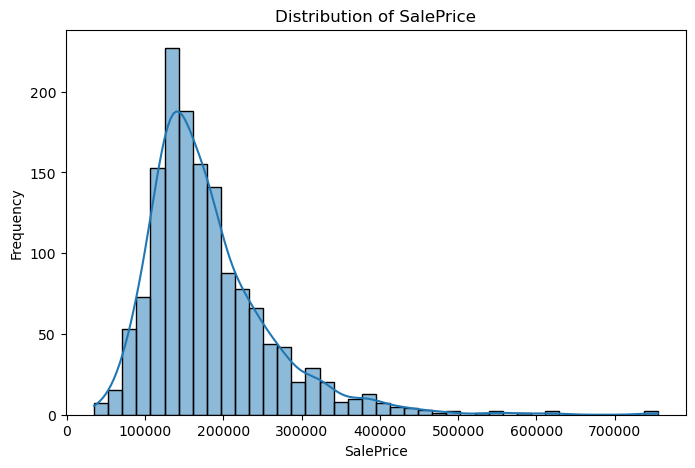

Skewness of SalePrice: 1.8828757597682129
Kurtosis of SalePrice: 6.536281860064529


In [51]:

# Check target variable distribution
plt.figure(figsize=(8,5))
sns.histplot(train_df["SalePrice"], kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

# Skewness of SalePrice
print("Skewness of SalePrice:", train_df["SalePrice"].skew())
print("Kurtosis of SalePrice:", train_df["SalePrice"].kurt())

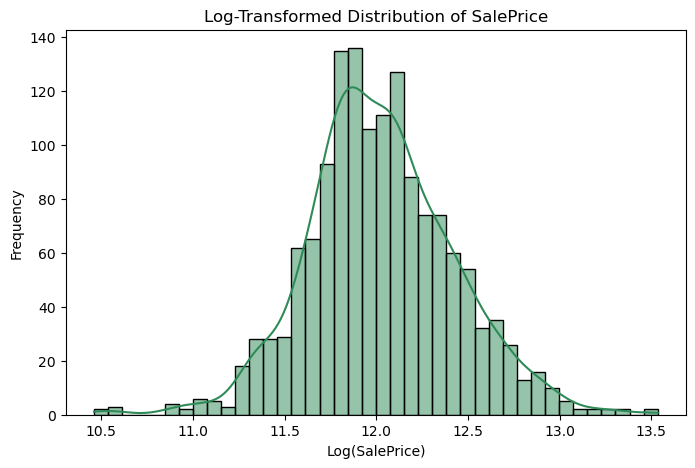

Log-transformed skew: 0.12134661989685333
Log-transformed kurtosis: 0.809519155707878


In [52]:
# ============================================ # 
# Log Transformation (for linear models) 
#  ============================================ 
train_df["SalePrice_Log"] = np.log1p(train_df["SalePrice"]) 
plt.figure(figsize=(8,5)) 
sns.histplot(train_df["SalePrice_Log"], kde=True, bins=40, color="seagreen") 
plt.title("Log-Transformed Distribution of SalePrice") 
plt.xlabel("Log(SalePrice)") 
plt.ylabel("Frequency") 
plt.show() 
print("Log-transformed skew:", train_df["SalePrice_Log"].skew()) 
print("Log-transformed kurtosis:", train_df["SalePrice_Log"].kurt())

### Exploratory Data Analysis

#### Univariate Analysis for All Numeric Columns

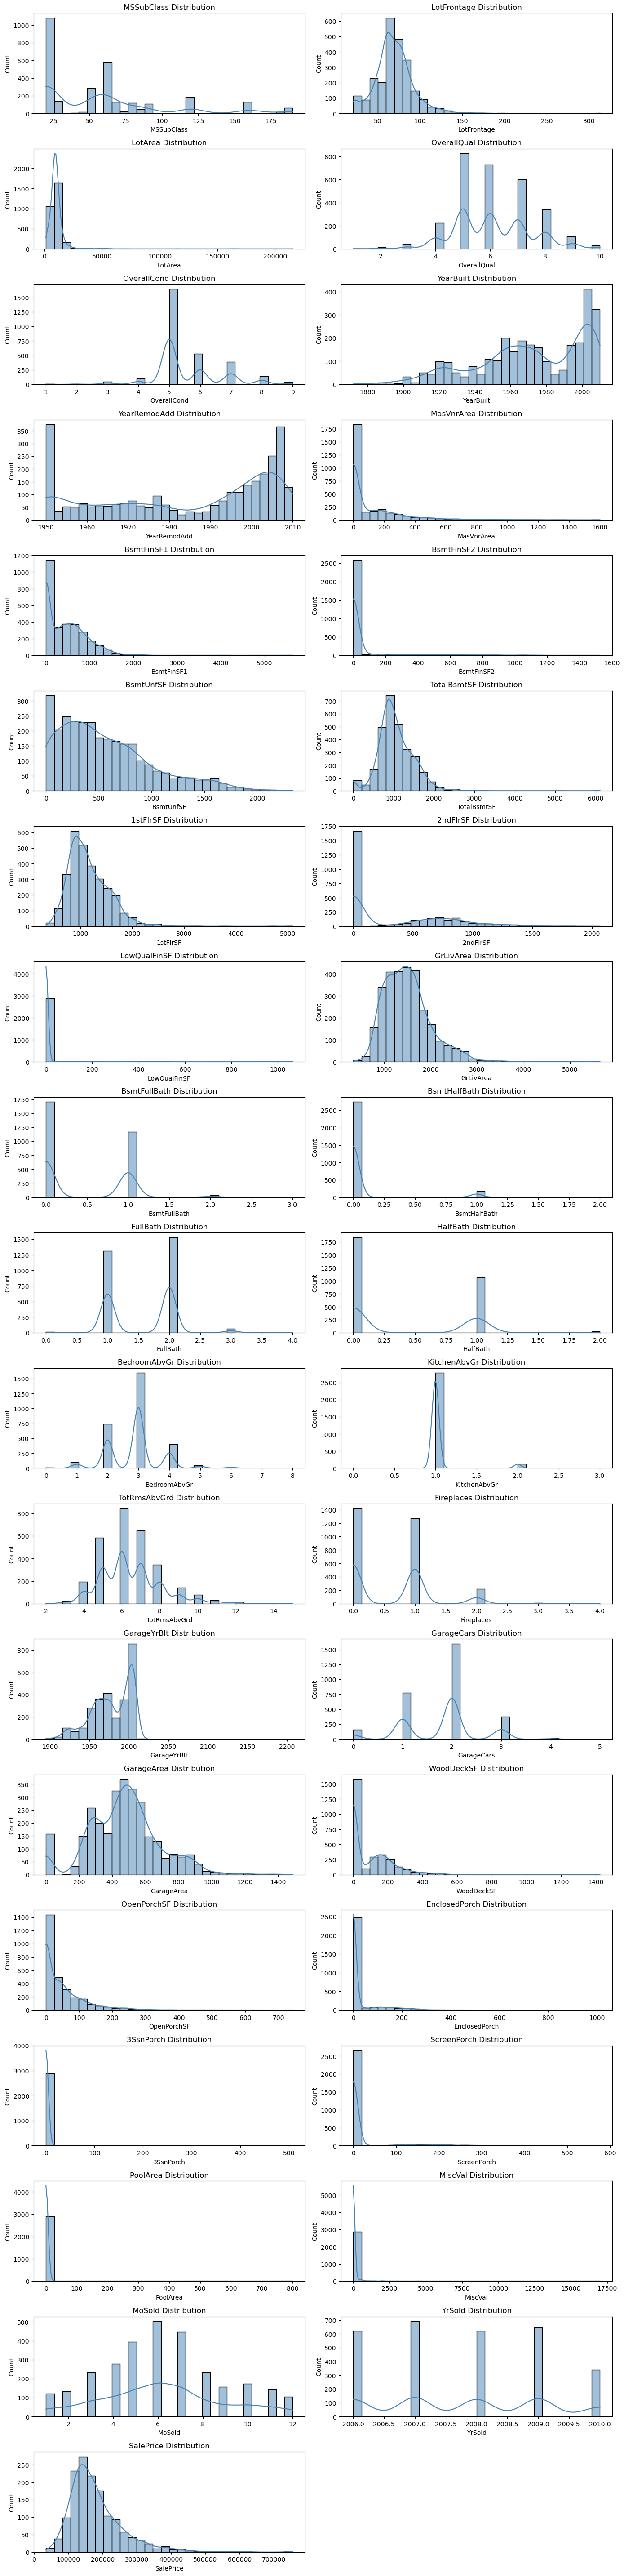

In [53]:


numeric_cols = full_df.select_dtypes(include=[np.number]).columns

# Set up grid size (2 columns per row)
n_cols = 2
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[1:-1]):  # Exclude ID and target variable
    sns.histplot(full_df[col], kde=True, bins=30, ax=axes[i], color="steelblue")
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Remove empty subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Correlation Matrix Shape: (39, 39)


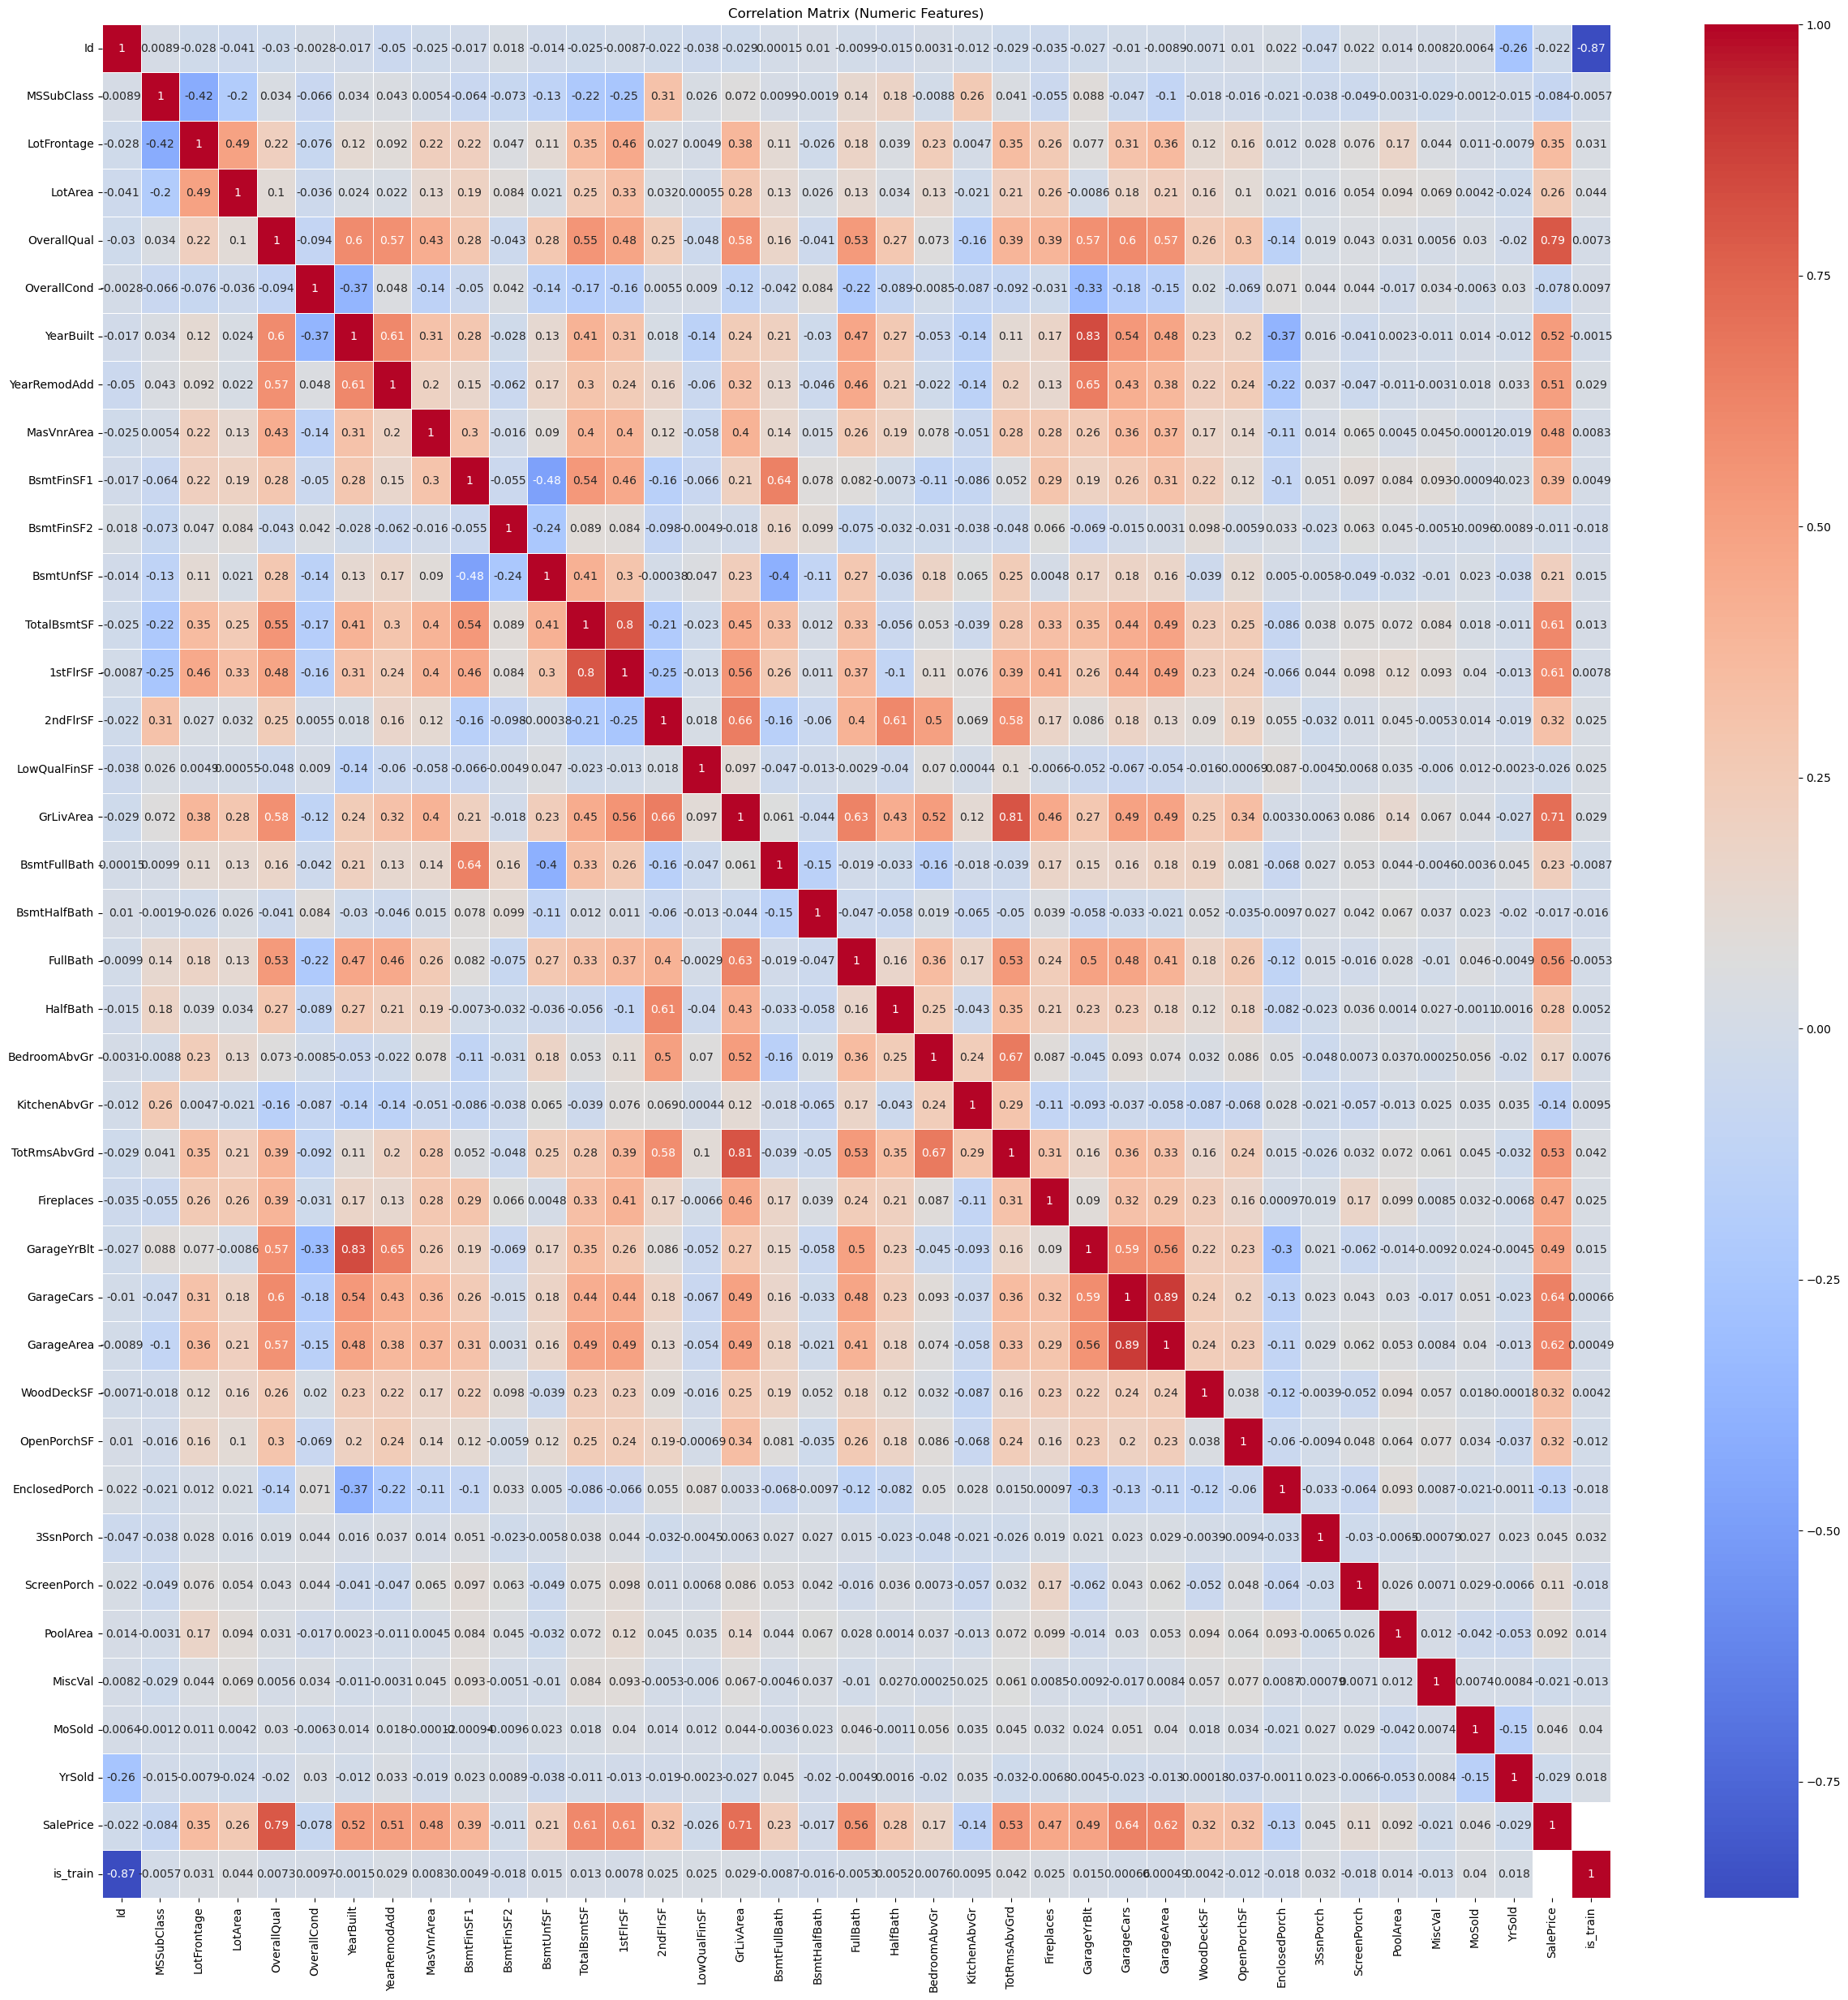

In [54]:
# ============================================
# Correlation Matrix for Numeric Features
# ============================================

# Compute correlation
corr_matrix = full_df.corr(numeric_only=True)

# Display correlation matrix (numeric only)
print("Correlation Matrix Shape:", corr_matrix.shape)

# Full heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


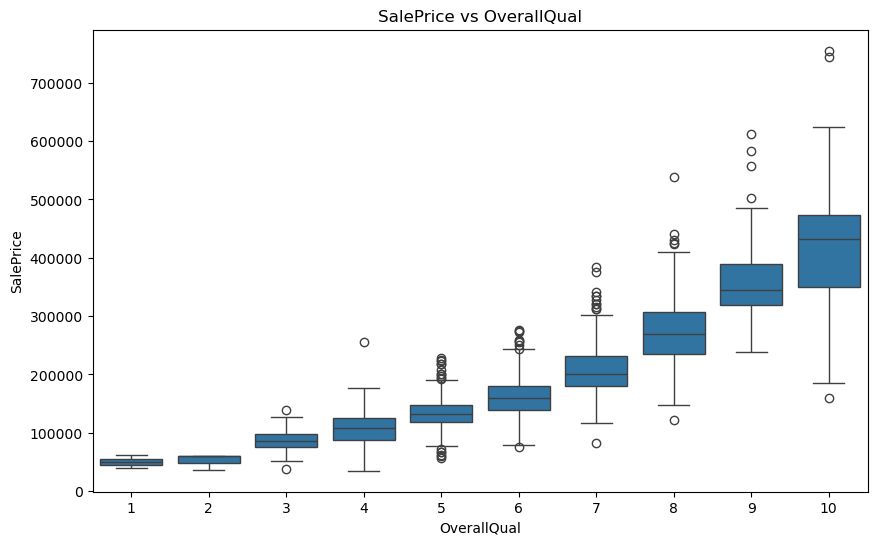

In [55]:

# ---------------------------
# Bivariate Analysis
# ---------------------------

# Categorical vs Target
plt.figure(figsize=(10,6))
sns.boxplot(x="OverallQual", y="SalePrice", data=train_df)
plt.title("SalePrice vs OverallQual")
plt.show()


### Data Cleaning

In [56]:
# ============================================
# Handling Duplicates
# ============================================

# Check for duplicates
duplicate_rows = full_df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# If any duplicates exist, inspect them
if duplicate_rows.sum() > 0:
    display(full_df[duplicate_rows].head())

# Drop duplicate rows
full_df = full_df.drop_duplicates().reset_index(drop=True)

print(f"Shape after removing duplicates: {full_df.shape}")


Number of duplicate rows: 0
Shape after removing duplicates: (2919, 82)


In [57]:
full_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
is_train            0
Length: 82, dtype: int64

In [58]:
# Drop useless cols
threshold = 0.05  # drop cols with >5% missing
full_df_sale = full_df["SalePrice"]
full_df = full_df.loc[:, full_df.isnull().mean() < threshold]   
full_df["SalePrice"] = full_df_sale  # add target back
full_df.shape

(2919, 70)

In [59]:
full_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotArea             0
Street              0
                 ... 
YrSold              0
SaleType            1
SaleCondition       0
is_train            0
SalePrice        1459
Length: 70, dtype: int64

In [60]:
# ---------------------------
# Handle Missing Values
# ---------------------------

# Identify numeric and categorical columns (excluding SalePrice)
num_cols = [col for col in full_df.select_dtypes(include=[np.number]).columns if col != "SalePrice"]
cat_cols = full_df.select_dtypes(exclude=[np.number]).columns

# Numeric features: fill with median
for col in num_cols:
    full_df[col] = full_df[col].fillna(full_df[col].median())

# Categorical features: fill with mode
for col in cat_cols:
    full_df[col] = full_df[col].fillna(full_df[col].mode()[0])

print("Missing values handled successfully!")

# ---------------------------
# Re-check Data
# ---------------------------
print("Remaining missing values:")
full_df.isnull().sum()


Missing values handled successfully!
Remaining missing values:


Id                  0
MSSubClass          0
MSZoning            0
LotArea             0
Street              0
                 ... 
YrSold              0
SaleType            0
SaleCondition       0
is_train            0
SalePrice        1459
Length: 70, dtype: int64

In [61]:
train_df.shape, test_df.shape, full_df.shape

((1460, 83), (1459, 82), (2919, 70))

### Feature Engineering

In [62]:
# Separate categorical and numeric features
categorical_cols = full_df.select_dtypes(include=["object"]).columns
numeric_cols = full_df.select_dtypes(exclude=["object"]).columns

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))
print(categorical_cols)

Numeric columns: 37
Categorical columns: 33
Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition'], dtype='object')


In [63]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Make a copy
encoded_df = full_df.copy()

label_encoders = {}
for col in encoded_df.select_dtypes(include="object"):
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    label_encoders[col] = le  # save encoder for deployment

In [64]:

# Save encoders for future use
with open("../models/encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# Split back into train/test after encoding
train_encoded = encoded_df[encoded_df["is_train"] == 1].drop(columns=["is_train"])
test_encoded  = encoded_df[encoded_df["is_train"] == 0].drop(columns=["is_train"])

# Save encoded datasets
train_encoded.to_csv("../data/regression_datasets/train_encoded.csv", index=False)
test_encoded.to_csv("../data/regression_datasets/test_encoded.csv", index=False)

In [65]:
#Verifying and checking the shape after encoding
categorical_cols = train_encoded.select_dtypes(include=["object"]).columns
numeric_cols = train_encoded.select_dtypes(exclude=["object"]).columns

print(train_df.shape)
print("Categorical columns:", len(categorical_cols))
print("Numeric columns:", len(numeric_cols))


(1460, 83)
Categorical columns: 0
Numeric columns: 69


In [66]:
print(train_encoded.shape)
print(test_encoded.shape)

(1460, 69)
(1459, 69)


In [67]:
train_encoded.head()

,Id,MSSubClass,MSZoning,LotArea,Street,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,8450,1,...,2,2008,8,4,208500.00
1,2,20,3,9600,1,...,5,2007,8,4,181500.00
2,3,60,3,11250,1,...,9,2008,8,4,223500.00
3,4,70,3,9550,1,...,2,2006,8,0,140000.00
4,5,60,3,14260,1,...,12,2008,8,4,250000.00


OverallQual    0.58
GrLivArea      0.11
TotalBsmtSF    0.04
2ndFlrSF       0.03
BsmtFinSF1     0.03
GarageCars     0.03
1stFlrSF       0.03
GarageArea     0.01
LotArea        0.01
YearBuilt      0.01
YearRemodAdd   0.01
Neighborhood   0.01
FullBath       0.01
TotRmsAbvGrd   0.01
MasVnrArea     0.01
OpenPorchSF    0.01
WoodDeckSF     0.00
BsmtUnfSF      0.00
BsmtQual       0.00
OverallCond    0.00
dtype: float64


<Axes: >

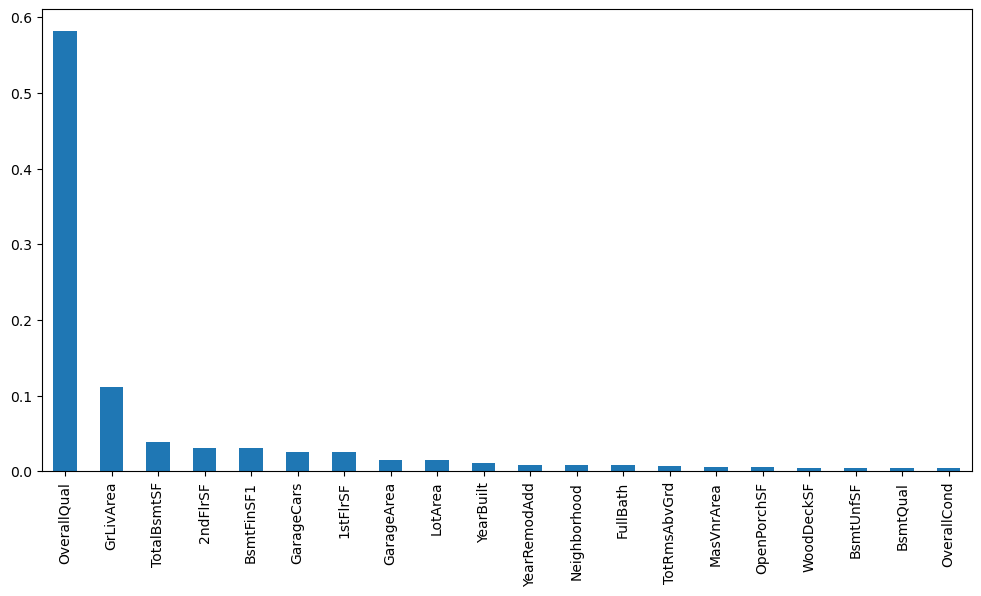

In [68]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

X = train_encoded.drop(["Id","SalePrice"], axis=1)
y = train_encoded["SalePrice"]

# Train a quick random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Show top 20
print(importances.head(20))

# Plot
importances.head(20).plot(kind="bar", figsize=(12,6))


In [69]:
# Set threshold for feature importance
threshold = 0.0009# keep features with >0.05% importance

important_features = importances[importances > threshold].index
X_reduced = X[important_features]

print(f"Original features: {X.shape[1]}")
print(f"Kept features: {X_reduced.shape[1]}")
print("Selected features:\n", list(important_features))

Original features: 67
Kept features: 38
Selected features:
 ['OverallQual', 'GrLivArea', 'TotalBsmtSF', '2ndFlrSF', 'BsmtFinSF1', 'GarageCars', '1stFlrSF', 'GarageArea', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'Neighborhood', 'FullBath', 'TotRmsAbvGrd', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtUnfSF', 'BsmtQual', 'OverallCond', 'KitchenQual', 'Fireplaces', 'MoSold', 'MSZoning', 'CentralAir', 'BsmtExposure', 'MSSubClass', 'ExterQual', 'Exterior1st', 'BsmtFinType1', 'YrSold', 'BedroomAbvGr', 'LandContour', 'SaleCondition', 'LotShape', 'HalfBath', 'Exterior2nd', 'LotConfig']


In [5]:
cols = [
    'OverallQual','GrLivArea','TotalBsmtSF','2ndFlrSF','BsmtFinSF1','GarageCars',
    '1stFlrSF','GarageArea','LotArea','YearBuilt','YearRemodAdd','Neighborhood',
    'FullBath','TotRmsAbvGrd','MasVnrArea','OpenPorchSF','WoodDeckSF','BsmtUnfSF',
    'BsmtQual','OverallCond','KitchenQual','Fireplaces','MoSold','MSZoning',
    'CentralAir','BsmtExposure','MSSubClass','ExterQual','Exterior1st','BsmtFinType1',
    'YrSold','BedroomAbvGr','LandContour','SaleCondition','LotShape','HalfBath',
    'Exterior2nd','LotConfig'
]

missing = [c for c in cols if c not in train_df.columns]
if missing:
    print("Missing columns:", missing)

data = train_df[[c for c in cols if c in train_df.columns]]
data.head()

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,GarageCars,1stFlrSF,GarageArea,LotArea,YearBuilt,...,Exterior1st,BsmtFinType1,YrSold,BedroomAbvGr,LandContour,SaleCondition,LotShape,HalfBath,Exterior2nd,LotConfig
0,7,1710,856,854,706,2,856,548,8450,2003,...,VinylSd,GLQ,2008,3,Lvl,Normal,Reg,1,VinylSd,Inside
1,6,1262,1262,0,978,2,1262,460,9600,1976,...,MetalSd,ALQ,2007,3,Lvl,Normal,Reg,0,MetalSd,FR2
2,7,1786,920,866,486,2,920,608,11250,2001,...,VinylSd,GLQ,2008,3,Lvl,Normal,IR1,1,VinylSd,Inside
3,7,1717,756,756,216,3,961,642,9550,1915,...,Wd Sdng,ALQ,2006,3,Lvl,Abnorml,IR1,0,Wd Shng,Corner
4,8,2198,1145,1053,655,3,1145,836,14260,2000,...,VinylSd,GLQ,2008,4,Lvl,Normal,IR1,1,VinylSd,FR2


In [70]:

train_encoded = pd.read_csv("../data/regression_datasets/train_encoded.csv")
test_encoded  = pd.read_csv("../data/regression_datasets/test_encoded.csv")

print(train_encoded.shape, test_encoded.shape)


(1460, 69) (1459, 69)


#### Data Spliting

In [71]:
top_features =  important_features

X = train_encoded[top_features]
y = train_encoded["SalePrice"]

X_test = test_encoded[top_features]
print(X.shape, X_test.shape)

(1460, 38) (1459, 38)


In [72]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Validation:", X_val.shape)


Train: (1168, 38) Validation: (292, 38)


#### With outliers

##### Random Forest Regressor

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rf_mae = mean_absolute_error(y_val, y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred)) 
print("Validation MAE:", rf_mae)
print("Validation RMSE:", rf_rmse)


Validation MAE: 17100.04292237443
Validation RMSE: 27237.8771699253


##### LGBM Regressor

In [74]:
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# LightGBM Regressor
lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit with early stopping using callbacks
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
)

# Predict
y_pred = lgbm.predict(X_val)

# Metrics
lgbm_mae = mean_absolute_error(y_val, y_pred)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("LightGBM Validation MAE:", lgbm_mae)
print("LightGBM Validation RMSE:", lgbm_rmse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2683
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 38
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

##### XGB Regressor

In [75]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=1000,       # number of trees
    learning_rate=0.05,      # step size shrinkage
    max_depth=6,             # tree depth
    subsample=0.8,           # subsample ratio
    colsample_bytree=0.8,    # features per tree
    random_state=42,
    n_jobs=-1
)

# Fit
xgb.fit(X_train, y_train, 
        eval_set=[(X_val, y_val)], 
        verbose=False)

# Predict
y_pred = xgb.predict(X_val)

# Metrics
xgb_mae = mean_absolute_error(y_val, y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # take square root manually
print("XGBoost Validation MAE:", xgb_mae)
print("XGBoost Validation RMSE:", xgb_rmse)


XGBoost Validation MAE: 15985.065670483733
XGBoost Validation RMSE: 25288.280406253743


In [76]:
import joblib
joblib.dump(xgb, "../models/xgb.pkl")

['../models/xgb.pkl']

In [77]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model =XGBRegressor(
    n_estimators=1000,       # number of trees
    learning_rate=0.05,      # step size shrinkage
    max_depth=6,             # tree depth
    subsample=0.8,           # subsample ratio
    colsample_bytree=0.8,    # features per tree
    random_state=42,
    n_jobs=-1
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fold {fold+1} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print("\nAverage MAE:", np.mean(mae_scores))
print("Average RMSE:", np.mean(rmse_scores))


Fold 1 - MAE: 15309.51, RMSE: 25489.01
Fold 2 - MAE: 14943.29, RMSE: 21657.44
Fold 3 - MAE: 18882.30, RMSE: 45326.68
Fold 4 - MAE: 16870.61, RMSE: 27965.80
Fold 5 - MAE: 13999.46, RMSE: 21580.11

Average MAE: 16001.033925513699
Average RMSE: 28403.80610829491


#### Without Outliers

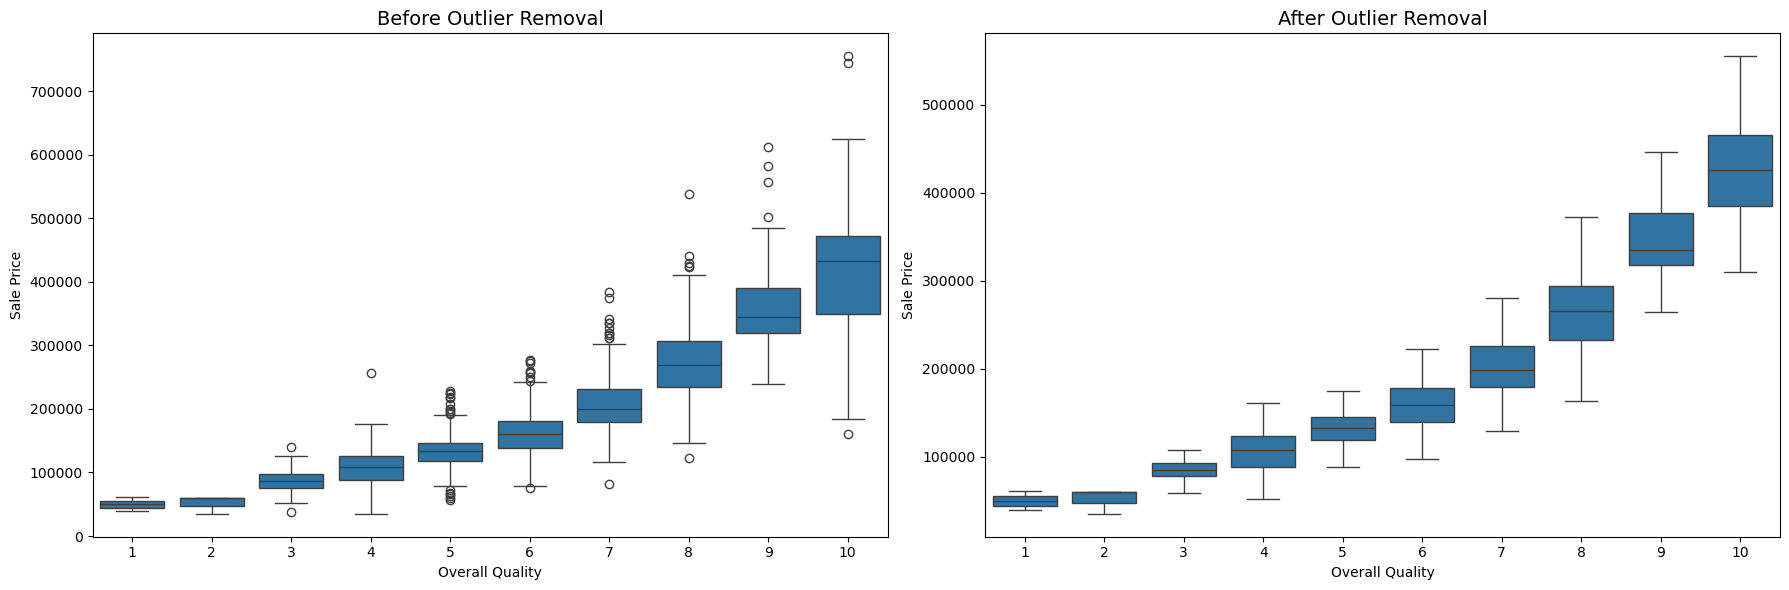

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Function to remove outliers groupwise ---
def remove_outliers_groupwise(df, group_col, target_col):
    cleaned_df = pd.DataFrame()
    for quality, group in df.groupby(group_col):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1 * IQR
        upper = Q3 + 1 * IQR
        group_clean = group[(group[target_col] >= lower) & (group[target_col] <= upper)]
        cleaned_df = pd.concat([cleaned_df, group_clean], axis=0)
    return cleaned_df

# --- Step 2: Remove outliers ---
df_cleaned = remove_outliers_groupwise(train_encoded, "OverallQual", "SalePrice")

# --- Step 3: Side-by-side boxplots ---
plt.figure(figsize=(18,6))

# Before outlier removal
plt.subplot(1, 2, 1)
sns.boxplot(data=train_encoded, x="OverallQual", y="SalePrice")
plt.title("Before Outlier Removal", fontsize=14)
plt.xlabel("Overall Quality")
plt.ylabel("Sale Price")

# After outlier removal
plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned, x="OverallQual", y="SalePrice")
plt.title("After Outlier Removal", fontsize=14)
plt.xlabel("Overall Quality")
plt.ylabel("Sale Price")

plt.tight_layout()
plt.show()


In [79]:
X = df_cleaned[top_features]
y = df_cleaned["SalePrice"]
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")


Train shape: (1060, 38)
Validation shape: (265, 38)


##### Random Forest Regressor

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rf_mae_clean = mean_absolute_error(y_val, y_pred)
rf_rmse_clean = np.sqrt(mean_squared_error(y_val, y_pred)) 
print("Validation MAE:", rf_mae_clean)
print("Validation RMSE:", rf_rmse_clean)

Validation MAE: 14392.781710691825
Validation RMSE: 19643.737952986197


##### LGBM Regressor

In [81]:
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# LightGBM Regressor
lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit with early stopping using callbacks
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
)

# Predict
y_pred = lgbm.predict(X_val)

# Metrics
lgbm_mae_clean = mean_absolute_error(y_val, y_pred)
lgbm_rmse_clean= np.sqrt(mean_squared_error(y_val, y_pred))
print("LightGBM Validation MAE:", lgbm_mae_clean)
print("LightGBM Validation RMSE:", lgbm_rmse_clean)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 38
[LightGBM] [Info] Start training from score 175521.779245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [82]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the model
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit on filtered data
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict and evaluate
y_pred = xgb.predict(X_val)
xgb_r2_clean = r2_score(y_val, y_pred)
xgb_mae_clean = mean_absolute_error(y_val, y_pred)
xgb_rmse_clean = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"XGBoost Validation R² after outlier removal: {xgb_r2_clean:.2f}")
print(f"XGBoost Validation MAE after outlier removal: {xgb_mae_clean:.2f}")
print(f"XGBoost Validation RMSE after outlier removal: {xgb_rmse_clean:.2f}")

import numpy as np

mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
print(f"XGBoost Validation MAPE: {mape:.2f}%")

tolerance = 5000  # units
within_tolerance = np.abs(y_val - y_pred) <= tolerance
regression_accuracy = np.mean(within_tolerance) * 100
print(f"Regression Accuracy (±{tolerance} units): {regression_accuracy:.2f}%")

import numpy as np

# Define tolerance (e.g., 10% of actual value)
tolerance = 0.2  # 20%

# Check which predictions are within tolerance
within_tolerance = np.abs(y_val - y_pred) <= tolerance * y_val

# Calculate “accuracy”
regression_accuracy = np.mean(within_tolerance) * 100

print(f"Regression Accuracy (±{tolerance*100:.0f}% tolerance): {regression_accuracy:.2f}%")


XGBoost Validation R² after outlier removal: 0.92
XGBoost Validation MAE after outlier removal: 13552.24
XGBoost Validation RMSE after outlier removal: 18297.11
XGBoost Validation MAPE: 7.81%
Regression Accuracy (±5000 units): 28.30%
Regression Accuracy (±20% tolerance): 93.96%


In [83]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.float_format', '{:.2f}'.format)  # optional formatting

#### Final Comparisons 

In [84]:

comparison_df = pd.DataFrame({
    "Dataset": ["Original RF","Cleaned RF","Original LGBM","Cleaned LGBM","Original XGB", "Cleaned XGB"],
    "MAE": [rf_mae,rf_mae_clean,lgbm_mae,lgbm_mae_clean,xgb_mae,xgb_mae_clean],
    "RMSE": [rf_rmse,rf_rmse_clean,lgbm_rmse,lgbm_rmse_clean,xgb_rmse,xgb_rmse_clean]
})

comparison_df


,Dataset,MAE,RMSE
0,Original RF,17100.04,27237.88
1,Cleaned RF,14392.78,19643.74
2,Original LGBM,15804.54,28490.77
3,Cleaned LGBM,13112.43,18213.65
4,Original XGB,15985.07,25288.28
5,Cleaned XGB,13552.24,18297.11


In [85]:
from IPython.display import display

# Format table with larger font and padding
df_table = (
    comparison_df.style
    .set_table_styles(
        [
            {"selector": "th", "props": [("font-size", "20px"), ("padding", "10px")]},
            {"selector": "td", "props": [("font-size", "16px"), ("padding", "10px")]},
        ]
    )
    .set_properties(**{'text-align': 'center'})
)

In [86]:
display(df_table)


,Dataset,MAE,RMSE
0,Original RF,17100.042922,27237.877170
1,Cleaned RF,14392.781711,19643.737953
2,Original LGBM,15804.537096,28490.769214
3,Cleaned LGBM,13112.425242,18213.651235
4,Original XGB,15985.065670,25288.280406
5,Cleaned XGB,13552.240183,18297.110257


In [87]:
import joblib
joblib.dump(xgb, "../models/xgb_final.joblib")
joblib.dump(xgb, "../models/xgb_final.pkl")

['../models/xgb_final.pkl']

In [101]:
import pandas as pd
import numpy as np
import joblib   # if you saved model with joblib
# from xgboost import XGBRegressor  # (optional if loading directly)

# =============================
# 1. Load training data
# =============================
train_df = pd.read_csv("../data/regression_datasets/train_encoded.csv")
train_df = train_df.iloc[:200]
# Separate target and features
y_true = train_df["SalePrice"]
X_train_eval = train_df[important_features]

# =============================
# 2. Load the trained model
# =============================
xgb_loaded = joblib.load("../models/xgb.pkl")  # or .sav / .joblib depending on what you used

# =============================
# 3. Align columns (important)
# =============================
# In case training pipeline used a subset of features
model_features = xgb_loaded.get_booster().feature_names

# Add any missing columns
for col in model_features:
    if col not in X_train_eval.columns:
        X_train_eval[col] = 0

# Reorder columns
X_train_eval = X_train_eval[model_features]

# =============================
# 4. Predict on training data
# =============================
y_pred_train = xgb_loaded.predict(X_train_eval)

# If target was log-transformed during training:
#y_pred_train = np.expm1(y_pred_train)

# =============================
# 5. Combine actual vs predicted
# =============================
results_df = train_df.copy()
results_df["Predicted_SalePrice"] = y_pred_train
results_df["Error"] = results_df["SalePrice"] - results_df["Predicted_SalePrice"]

# =============================
# 6. Evaluate performance
# =============================
# from sklearn.metrics import r2_score, mean_absolute_error

# r2 = r2_score(y_true, y_pred_train)
# mae = mean_absolute_error(y_true, y_pred_train)
# rmse = mean_squared_error(y_true, y_pred_train, squared=False)

# print(f"📊 R²: {r2:.4f}")
# print(f"📉 MAE: {mae:.2f}")
# print(f"📉 RMSE: {rmse:.2f}")

# =============================
# 7. Save output with predictions
# =============================
results_df.to_csv("submission.csv", index=False)


In [102]:
results_df.head(10)

,Id,MSSubClass,MSZoning,LotArea,Street,...,SaleType,SaleCondition,SalePrice,Predicted_SalePrice,Error
0,1,60,3,8450,1,...,8,4,208500.00,208338.23,161.77
1,2,20,3,9600,1,...,8,4,181500.00,181629.00,-129.00
2,3,60,3,11250,1,...,8,4,223500.00,223470.22,29.78
3,4,70,3,9550,1,...,8,0,140000.00,140061.78,-61.78
4,5,60,3,14260,1,...,8,4,250000.00,250095.34,-95.34
5,6,50,3,14115,1,...,8,4,143000.00,143140.95,-140.95
6,7,20,3,10084,1,...,8,4,307000.00,306879.38,120.62
7,8,60,3,10382,1,...,8,4,200000.00,200065.55,-65.55
8,9,50,4,6120,1,...,8,0,129900.00,129886.76,13.24
9,10,190,3,7420,1,...,8,4,118000.00,118020.28,-20.28


In [103]:
mape = (abs(results_df["Error"]) / results_df["SalePrice"]).mean() * 100
accuracy = 100 - mape
print(f"MAPE: {mape:.2f}%")
print(f"Approx. Accuracy: {accuracy:.2f}%")

MAPE: 2.09%
Approx. Accuracy: 97.91%


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_true, y_pred_train)
mae = mean_absolute_error(y_true, y_pred_train)

print(f"📊 R²: {r2:.4f}")
print(f"📉 MAE: {mae:.2f}")

📊 R²: 0.9875
📉 MAE: 2724.38


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================
# 1. Load full dataset
# =============================
df = pd.read_csv("../data/regression_datasets/train_encoded.csv")
y = df[target_col]
df = df[important_features]
# ✅ Separate target and features
target_col = "SalePrice"
X = df.copy()

# =============================
# 2. Recreate Train/Test split with SAME random_state
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================
# 3. Load trained model
# =============================
xgb_loaded = joblib.load("../models/xgb_final.pkl")

# =============================
# 4. Align columns with model features
# =============================
model_features = xgb_loaded.get_booster().feature_names

# Add any missing columns in test set
for col in model_features:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns to match training order
X_test = X_test[model_features]

# =============================
# 5. Predict on test set
# =============================
y_pred = xgb_loaded.predict(X_test)

# If target was log-transformed during training:
# y_pred = np.expm1(y_pred)

# =============================
# 6. Evaluate performance
# =============================
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# =============================
# 7. Save output with predictions
# =============================
results_df = X_test.copy()
results_df["Actual_SalePrice"] = y_test
results_df["Predicted_SalePrice"] = y_pred
results_df["Error"] = results_df["Actual_SalePrice"] - results_df["Predicted_SalePrice"]

results_df.to_csv("test_predictions.csv", index=False)
print(" Predictions saved to 'test_predictions.csv'")


📊 R² Score: 0.9176
📉 MAE: 7674.55
📉 RMSE: 25134.91
✅ Predictions saved to 'test_predictions.csv'


In [113]:
results_df.head(10)

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,...,Exterior2nd,LotConfig,Actual_SalePrice,Predicted_SalePrice,Error
892,6,1068,1059.00,0,663.00,...,6,4,154500.00,154406.66,93.34
1105,8,2622,1463.00,1122,1032.00,...,6,0,325000.00,329342.16,-4342.16
413,5,1028,1008.00,0,0.00,...,15,4,115000.00,114877.38,122.62
522,6,1664,1004.00,660,399.00,...,5,0,159000.00,159014.34,-14.34
1036,9,1620,1620.00,0,1022.00,...,13,4,315500.00,315499.31,0.69
614,4,630,630.00,0,150.00,...,5,4,75500.00,75520.99,-20.99
218,7,1954,798.00,817,341.00,...,13,0,311500.00,227415.19,84084.81
1160,6,1456,855.00,601,311.00,...,2,4,146000.00,146170.48,-170.48
649,4,630,630.00,0,131.00,...,5,4,84500.00,84475.70,24.30
887,5,1393,816.00,521,0.00,...,8,4,135500.00,135456.06,43.94


In [110]:
mape = (abs(results_df["Error"]) / results_df["Actual_SalePrice"]).mean() * 100
accuracy = 100 - mape
print(f"MAPE: {mape:.2f}%")
print(f"Approx. Accuracy: {accuracy:.2f}%")

MAPE: 4.34%
Approx. Accuracy: 95.66%
